In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) #視覺圖放大一倍，預設 (8.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
import seaborn as sns
sns.set()
import numpy as np
import re
from pandas.core.frame import DataFrame

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
#pd.set_option('display.max_rows', None)
#pd.set_option('max_colwidth',100)

In [2]:
#讀入資料
HomeCDT_train=pd.read_csv("C:/Shared/Final_topic/home-credit-default-risk/application_train.csv")
HomeCDT_previous=pd.read_csv("C:/Shared/Final_topic/home-credit-default-risk/previous_application.csv")

# HomeCDT_train=pd.read_csv("D:/BigData/machine_learning/2.5G_home-credit-default-risk/application_train.csv")
# HomeCDT_previous=pd.read_csv("D:/BigData/machine_learning/2.5G_home-credit-default-risk/previous_application.csv")

In [39]:
def data_unique(data):
    '''data = 資料集
       計算唯一值個數
    '''
    data = data.apply(lambda x:x.unique().shape[0],axis=0)
    print(data)

def set_col_names(data):
    '''data = 資料集
       建立columns names list
    '''
    global col_names
    col_names = []
    col_names = data.columns

def set_col_type(data):
    '''data = 資料集
       建立columns names 列向量的名稱的list
    '''
    global col_type
    col_type = []
    for i in col_names:
        col_type.append(data[i].values.dtype)

def set_col_type_df(col_names, col_type):
    '''建立colums name的資料框
       colum
    '''
    global col_type_df
    col_Dict={"col_names" : col_names,
              "col_type" : col_type}

    col_type_df=DataFrame(col_Dict)
    
def Create_list(columes_type,col):
    '''columes_type = 列欄位的type 型態要是list
       col_names = 列欄位的names 型態要是list
       將不同資料型態放入各自的list，使用到全域變數，整數、物件、浮點數分類
    '''
    global type_Int64 
    global type_object 
    global type_float64 

    type_Int64 = []
    type_object = []
    type_float64 = []
    
    list_tmp = col_type_df["col_type"]
    list_tmp = list_tmp.values.tolist()
    for i in range(len(col_type)):
        if list_tmp[i] == "int64":
            type_Int64.append(col[i])
        elif list_tmp[i] == "O":
            type_object.append(col[i])
        elif list_tmp[i] == "float64":
            type_float64.append(col[i])
            
def set_train_null(data):
    '''data = 資料集
       挑選出有空值的欄位
       判斷是否有空值
    '''
    global train_null
    count_null = data.isnull().any()
    train_null = data.isnull().sum()[count_null==True]
    
def plot_null_hist(train_null):
    '''train_null = 放入有空值的columns 名稱及個數
    '''
    plt.figure(figsize=(20, 40), dpi=70)
    
    plt.subplot2grid((4,2),(0,0))
    train_null[0:8].plot(kind='bar')
    plt.subplot2grid((4,2),(0,1))
    train_null[8:16].plot(kind='bar')
    
def plot_int_hist(data, type_Int64):
    '''data = 資料集
       type_int64 放入type_Int64 型態的columns names
       畫出int類型的直方分布圖
    '''
    for i in range(len(type_Int64)):
        fig,axes = plt.subplots()
        data[type_Int64[i]].plot.hist(bins=50,ax=axes)
        axes.set_title(type_Int64[i])
        
def coefficient(data, type_float64):
    '''data = 資料集
       type_float64 放入type_float64 型態的columns names
       float64 合併目標項並計算相關係數
    '''
    global corDf
    type_float64_df = data[type_float64]

    corDf=type_float64_df.corr()
    print(corDf["TARGET"])
    
def plot_coefficient(data, type_float64):
    '''data = 資料集
       type_float64 放入type_float64 型態的columns names
       畫出相關係數熱圖
    '''
    type_float64_df = data[type_float64]
    type_float64_df["TARGET"] = data["TARGET"]
    plt.figure(figsize=(30, 30))

    g=sns.heatmap(np.abs(corDf), vmin=0., vmax=1., linewidths=0.01,
                square=True,annot=True,cmap='YlGnBu',linecolor="white")
    plt.title('Correlation between features');
    
def plot_pie_chart(type_object, data):
    '''type_object = 放入type_object 型態的columns names
       data = 資料集
       畫圓餅圖,需要有type_object,針對object
    '''
    for j in type_object:
        list_unique = data[j].unique().tolist()
        print("")
        print("")
        print(j)
        for i in range (0,len(list_unique)):
            print ( list_unique[i], ' : ',(list_unique[i] == data[j].values ).sum().tolist() ,sep='' )
            num=[]
        for i in range (0,len(list_unique)):
            num.append((list_unique[i] == data[j].values ).sum().tolist())
            lab=list(zip(list_unique,num))
        plt.pie( num, labels = lab , autopct = '%1.1f%%')
        plt.axis('equal')
        plt.show()
        
def merge_target(data1, data2):
    '''data1 = 原資料(沒有target的),
       data2 = 被合併的資料(有target的)
       將目標項根據 ID 合併到資料中 
       並target裡面有缺失值的 row 都刪除
    '''
    HomeCDT_merge = pd.merge(data1, data2, how='left', on='SK_ID_CURR')
    data1 = pd.concat([data1,HomeCDT_merge['TARGET']],axis=1)

    data1 = data1.dropna(subset=['TARGET'])

In [4]:
#將目標項根據 ID 合併到資料中
#target裡面有缺失值的 row 都刪除
HomeCDT_merge = pd.merge(HomeCDT_previous, HomeCDT_train, how='left', on='SK_ID_CURR')
HomeCDT_previous = pd.concat([HomeCDT_previous,HomeCDT_merge['TARGET']],axis=1)

HomeCDT_previous = HomeCDT_previous.dropna(subset=['TARGET'])
HomeCDT_previous.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.0


In [5]:
len(HomeCDT_previous['SK_ID_PREV'])

1413701

In [7]:
#計算唯一值個數 previous
data_unique(HomeCDT_previous)

SK_ID_PREV                     1413701
SK_ID_CURR                      291057
NAME_CONTRACT_TYPE                   4
AMT_ANNUITY                     329538
AMT_APPLICATION                  86766
AMT_CREDIT                       81731
AMT_DOWN_PAYMENT                 26864
AMT_GOODS_PRICE                  86767
WEEKDAY_APPR_PROCESS_START           7
HOUR_APPR_PROCESS_START             24
FLAG_LAST_APPL_PER_CONTRACT          2
NFLAG_LAST_APPL_IN_DAY               2
RATE_DOWN_PAYMENT               185079
RATE_INTEREST_PRIMARY              137
RATE_INTEREST_PRIVILEGED            24
NAME_CASH_LOAN_PURPOSE              25
NAME_CONTRACT_STATUS                 4
DAYS_DECISION                     2922
NAME_PAYMENT_TYPE                    4
CODE_REJECT_REASON                   9
NAME_TYPE_SUITE                      8
NAME_CLIENT_TYPE                     4
NAME_GOODS_CATEGORY                 27
NAME_PORTFOLIO                       5
NAME_PRODUCT_TYPE                    3
CHANNEL_TYPE             

In [8]:
#建立列欄位名稱的 list
set_col_names(HomeCDT_previous)
col_names

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'TARGET'],
      dtype='object')

In [9]:
#建立 type of column list
set_col_type(HomeCDT_previous)
col_type

[dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64')]

In [10]:
#合併 col_names 和 col_type 變成 Dataframe
set_col_type_df(col_names, col_type)
col_type_df

,col_names,col_type
0,SK_ID_PREV,int64
1,SK_ID_CURR,int64
2,NAME_CONTRACT_TYPE,object
3,AMT_ANNUITY,float64
4,AMT_APPLICATION,float64
5,AMT_CREDIT,float64
6,AMT_DOWN_PAYMENT,float64
7,AMT_GOODS_PRICE,float64
8,WEEKDAY_APPR_PROCESS_START,object
9,HOUR_APPR_PROCESS_START,int64


In [11]:
#將不同資料型態放入各自的list，使用到全域變數，應該能有不用到全域變數的方法
#整數、物件、浮點數分類
Create_list(col_type,col_names)
type_Int64
# type_float64
# type_object

['SK_ID_PREV',
 'SK_ID_CURR',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'DAYS_DECISION',
 'SELLERPLACE_AREA']

In [12]:
#挑選出有空值的欄位
#判斷是否有空值
set_train_null(HomeCDT_previous)
train_null

AMT_ANNUITY                   307218
AMT_CREDIT                         1
AMT_DOWN_PAYMENT              749540
AMT_GOODS_PRICE               319525
RATE_DOWN_PAYMENT             749540
RATE_INTEREST_PRIMARY        1408910
RATE_INTEREST_PRIVILEGED     1408910
NAME_TYPE_SUITE               694672
CNT_PAYMENT                   307213
PRODUCT_COMBINATION              313
DAYS_FIRST_DRAWING            561106
DAYS_FIRST_DUE                561106
DAYS_LAST_DUE_1ST_VERSION     561106
DAYS_LAST_DUE                 561106
DAYS_TERMINATION              561106
NFLAG_INSURED_ON_APPROVAL     561106
dtype: int64

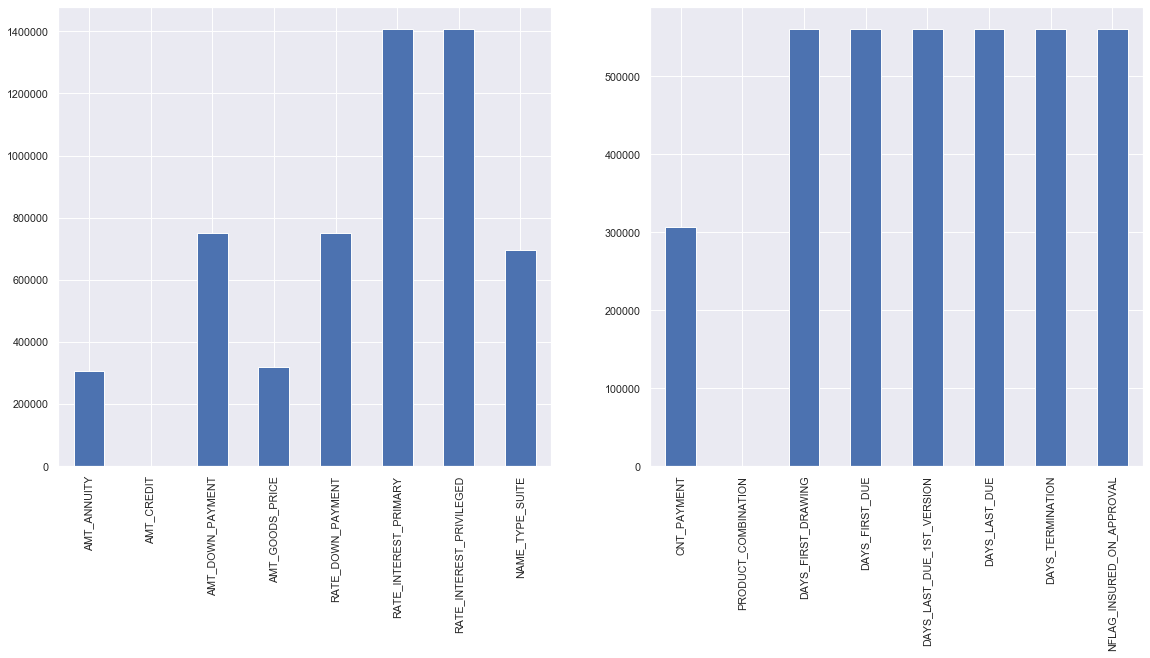

In [40]:
#針對空值看空值數目
#畫圖
plot_null_hist(train_null)

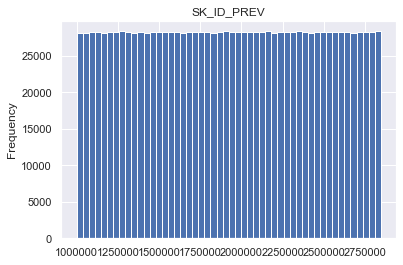

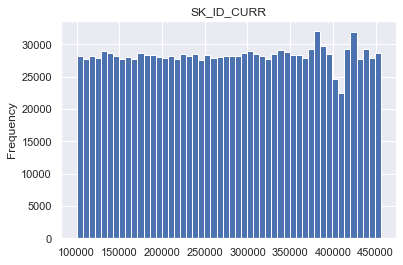

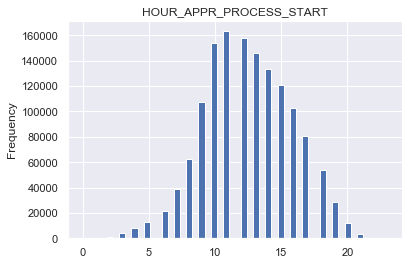

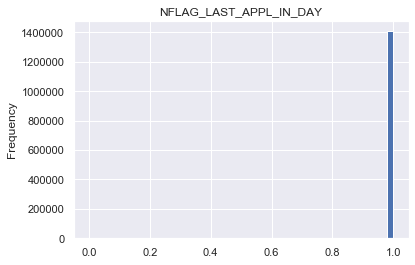

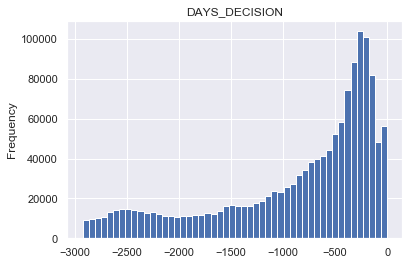

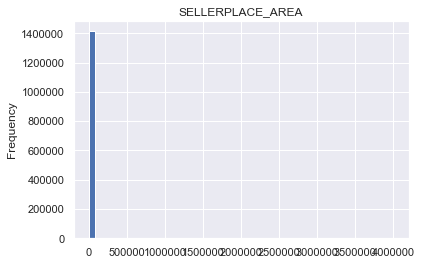

In [33]:
#數值型看分佈圖
plot_int_hist(HomeCDT_previous, type_Int64)

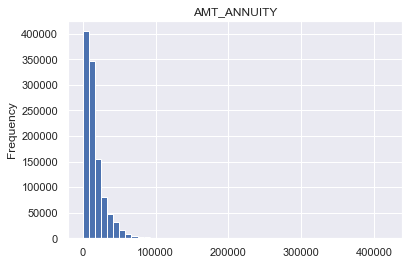

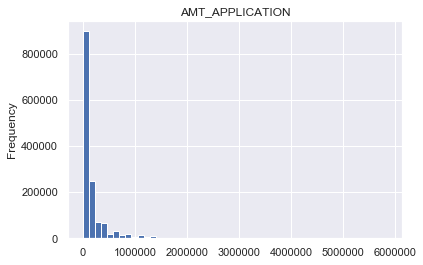

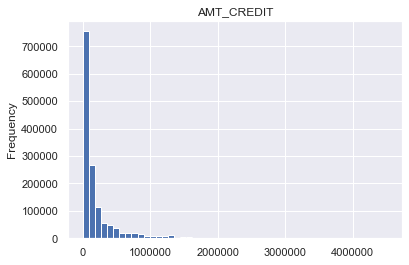

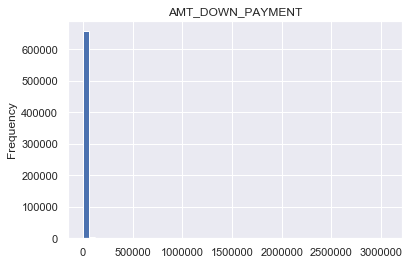

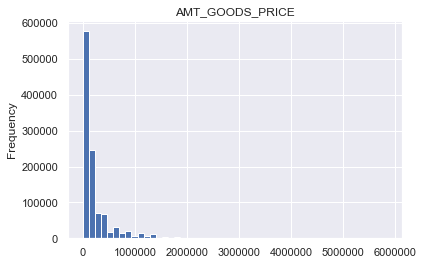

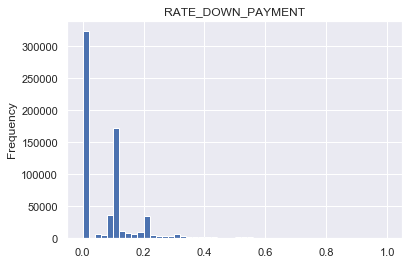

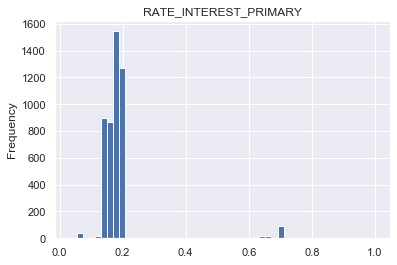

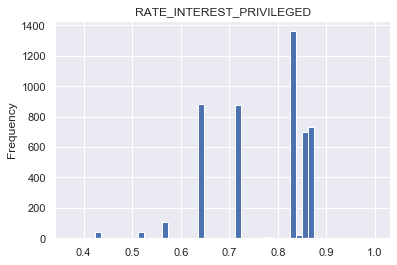

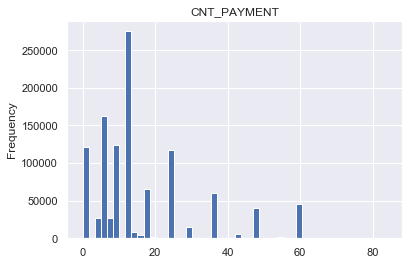

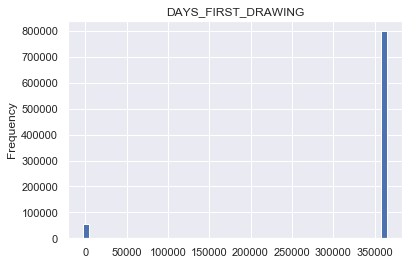

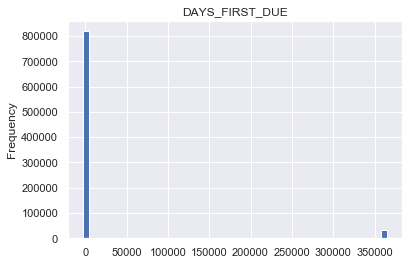

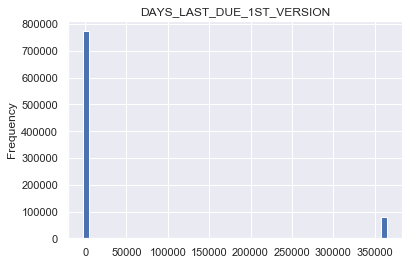

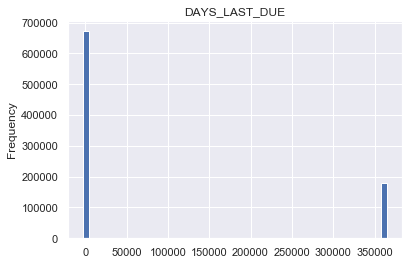

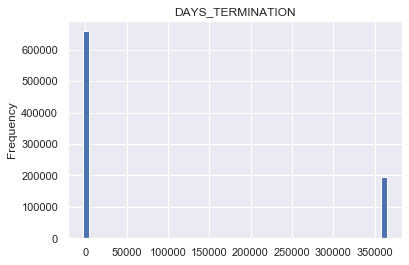

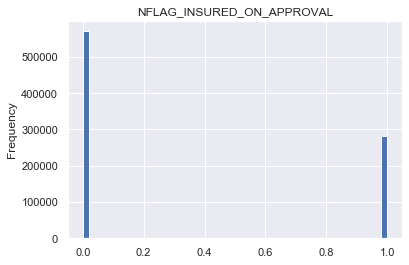

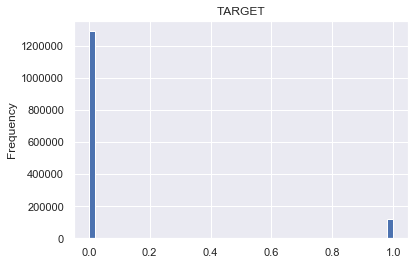

In [15]:
plot_int_hist(HomeCDT_previous, type_float64)

In [ ]:
#針對 float64 建立 Dataframe 合併目標項
#計算相關係數 
coefficient(HomeCDT_previous, type_float64)

In [ ]:
#畫其他和 target 相關係數熱圖
plot_coefficient(HomeCDT_previous, type_float64)

In [ ]:
# object 看各個 object 資料的分布 的圓餅圖
plot_pie_chart(type_object, HomeCDT_previous)